In [3]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors
import seaborn as sns

import scipy.stats

## Publication data

In [4]:
# authorPublicationData = pd.read_csv('data/author_publications_1970_2016_asiansAsNone.txt')
authorPublicationData = pd.read_csv('data/author_publications_2017_asiansAsNone.txt')
authorPublicationData.head()

,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [5]:
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [6]:
author_year_numPub.head()

author                 year
'maseka lesaoana       2001    1
                       2015    1
(max) zong-ming cheng  2009    1
                       2011    1
(zhou) bryan bai       2011    1
Name: pub_id, dtype: int64

In [31]:
author_year_publications = authorPublicationData.groupby(['author', 'year'])['pub_id'].apply(list)

In [8]:
# author_year_publications.head()

## Author citation data (ids)

In [9]:
authorCitationsData = pd.read_csv('./data/citations_2017_asiansAsNone_cleaned.txt')

In [10]:
authorCitationsData.head()
print(authorCitationsData.shape)

(24976435, 3)


In [11]:
paper_citation_count = pd.read_csv('data/paper-citation-count.csv', index_col=0, header=None, squeeze=True)

## Author citation network, paper -> author

In [12]:
# authorCitationsData_with_cited_author = pd.read_csv('./data/authors_cited_by_papers_2017_asiansAsNone_by_daniel.txt')

In [13]:
# authorCitationsData_with_cited_author.head()

In [14]:
citations_year_auth = pd.read_csv('./data/authors_cite_2017_asiansAsNone_by_daniel_grouped.txt')

In [15]:
final_citation_count = citations_year_auth.groupby('author')['cit_count'].sum()

In [16]:
citations_year_auth = citations_year_auth.groupby(['author', 'year_cit'])['cit_count'].sum()

## Author career information

In [17]:
CAREER_LENGTH = 5

In [18]:
credible_authors = pd.read_csv('data/authors-scientific-atleast-' + str(CAREER_LENGTH) + '-year.csv')

In [19]:
credible_authors.set_index('author', inplace=True)

In [20]:
credible_authors.head()

,start_year,end_year,num_pub,career_length
author,,,,
'maseka lesaoana,2001,2015,2,15
a aart blokhuis,1992,2005,2,14
a min tjoa,1979,2017,191,39
a-imam al-sammak,1992,2006,3,15
a-long jin,2011,2016,9,6


## Early career analysis

In [19]:
# This part adds data to credible_authors file. This is stored for later use. 

In [20]:
# credible_authors = credible_authors.head(5000)

In [21]:
EARLY_CAREER_LEN = 3
QUALITY_CUT_OFF = CAREER_LENGTH

In [22]:
def get_early_career_prod(row, early_career_len):
    early_prod = 0
    author = row.name
    start_year = row['start_year']
    year_num_pub = author_year_numPub[author]
    for year in range(early_career_len):
        if start_year + year in year_num_pub:
            early_prod += year_num_pub[start_year + year]
    return early_prod

In [23]:
%%time
credible_authors['early_career_prod'] = credible_authors.apply(lambda x: get_early_career_prod(x, EARLY_CAREER_LEN), axis=1)

CPU times: user 2min 53s, sys: 956 ms, total: 2min 54s
Wall time: 2min 54s


In [24]:
def get_early_publications(row, early_career_len):
    early_pubs = []
    author = row.name
    start_year = row['start_year']
    year_pub_list = author_year_publications[author]
    for year in range(early_career_len):
        if start_year + year in year_pub_list:
            early_pubs.extend(year_pub_list[start_year + year])
    return early_pubs

In [32]:
%%time
credible_authors['early_career_pubs'] = credible_authors.apply(lambda x: get_early_publications(x, EARLY_CAREER_LEN), axis=1)

CPU times: user 3min 39s, sys: 2.53 s, total: 3min 42s
Wall time: 3min 42s


In [26]:
def get_early_career_quality(row, cut_off):
    early_pubs = row.early_career_pubs
    start_year = row['start_year']
    return authorCitationsData[(authorCitationsData.id2.isin(early_pubs)) & 
                               (authorCitationsData.year_cit < start_year + cut_off)].shape[0]
    return sum([paper_citation_count[paper] for paper in early_pubs if paper in paper_citation_count])

In [ ]:
%%time
credible_authors['early_career_qual'] = credible_authors.apply(lambda x: get_early_career_quality(x, QUALITY_CUT_OFF), axis=1)
# early_career_quality = pd.read_csv('./data/early_career_quality.txt')
# early_career_quality.set_index('author', inplace=True)
# credible_authors['early_career_qual'] = early_career_quality

In [ ]:
credible_authors['early_career_qual'] = credible_authors['early_career_qual'].fillna(0)

In [30]:
def get_early_career_recognition(row, early_career_len):
    early_rec = 0
    author = row.name
    start_year = row['start_year']
    if author in citations_year_auth:
        year_num_cit = citations_year_auth[author]
    else:
        return 0
    for year in range(early_career_len):
        if start_year + year in year_num_cit:
            early_rec += year_num_cit[start_year + year]
    return early_rec

In [31]:
%%time
credible_authors['early_career_rec'] = credible_authors.apply(lambda x: get_early_career_recognition(x, EARLY_CAREER_LEN), axis=1)

CPU times: user 2min 46s, sys: 676 ms, total: 2min 46s
Wall time: 2min 46s


In [32]:
%%time
credible_authors['final_citation_count'] = final_citation_count
credible_authors['final_citation_count'] = credible_authors['final_citation_count'].fillna(0)

CPU times: user 464 ms, sys: 36 ms, total: 500 ms
Wall time: 496 ms


## Gender


In [33]:
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')
gender.set_index('name', inplace=True)

In [34]:
credible_authors['gender'] = gender

In [35]:
credible_authors.gender.value_counts()

m       249450
none    193670
f        60739
Name: gender, dtype: int64

## Save author data

In [36]:
credible_authors.reset_index().to_csv('data/authors-scientific-atleast-' + str(CAREER_LENGTH) + '-year_extended.csv', 
                                      index=False)

## Test for errors in files

### Test if final citation count is working correctly

In [37]:
final_less_than_early = credible_authors[credible_authors.final_citation_count < credible_authors.early_career_qual].shape
assert final_less_than_early[0] == 0, "Final citation count is smaller than early in {} cases.".format(final_less_than_early[0])

In [38]:
credible_authors[credible_authors.final_citation_count < credible_authors.early_career_qual].head()

,start_year,end_year,num_pub,career_length,early_career_prod,early_career_qual,early_career_rec,final_citation_count,gender
author,,,,,,,,,


In [39]:
# Look for authors with more than 20K citations. Are they famous?
authors_5k = credible_authors[credible_authors['final_citation_count'] > 5000]

In [40]:
authors_5k.index

Index(['a. lee swindlehurst', 'a. robert calderbank', 'aapo hyvärinen',
       'aaron f. bobick', 'aaron hertzmann', 'adi shamir', 'adrian perrig',
       'aggelos k. katsaggelos', 'ajith abraham', 'alan burns',
       ...
       'zheng chen', 'zhengyou zhang', 'zhi-hua zhou', 'zhi-quan luo',
       'zhou wang', 'zhu han', 'zhuoqing morley mao', 'zidong wang',
       'zoubin ghahramani', 'éva tardos'],
      dtype='object', name='author', length=915)

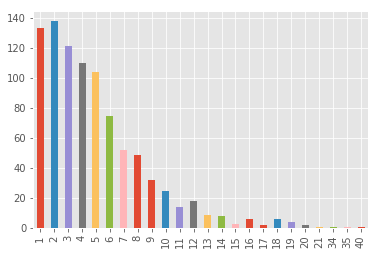

In [41]:
authors_5k.early_career_prod.value_counts().sort_index().plot(kind='bar')

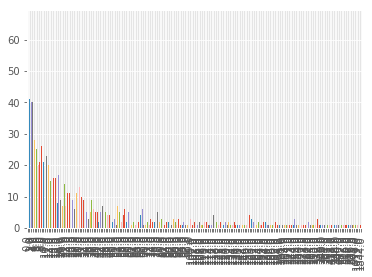

In [42]:
authors_5k.early_career_qual.value_counts().sort_index().plot(kind='bar')

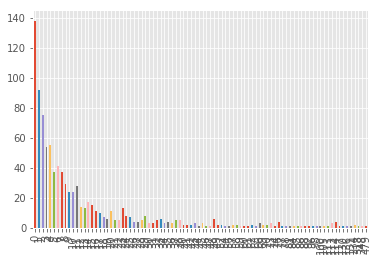

In [43]:
authors_5k.early_career_rec.value_counts().sort_index().plot(kind='bar')

In [44]:
authors_5k[authors_5k.early_career_rec > authors_5k.early_career_qual]

,start_year,end_year,num_pub,career_length,early_career_prod,early_career_qual,early_career_rec,final_citation_count,gender
author,,,,,,,,,


In [45]:
#credible_authors.drop(authors_20k, inplace=True)

In [46]:
# Test for extremly high early productivity
# credible_authors[(credible_authors.early_career_prod_1 >= 10)].shape

In [47]:
# credible_authors[(credible_authors.early_career_prod_1 >= 10)].start_year.value_counts().sort_index().plot(kind='bar')

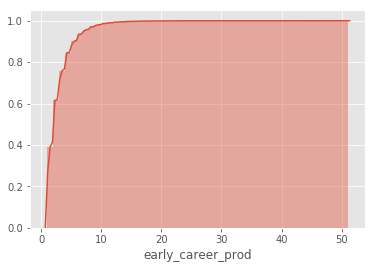

In [48]:
sns.distplot(credible_authors.early_career_prod,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
import scipy
sns.set_palette("hls", 1)

# x,y = p.get_lines()[0].get_data()

#care with the order, it is first y
#initial fills a 0 so the result has same length than x
# cdf = scipy.integrate.cumtrapz(y, x, initial=0)

# nearest_05 = np.abs(cdf-0.5).argmin()

# x_median = x[nearest_05]
# y_median = y[nearest_05]

# plt.vlines(x_median, 0, y_median)
plt.show()

### Test gender files

In [49]:
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')

In [50]:
gender_old = pd.read_csv('./data/name_gender_2017_asiansAsNone.txt')

In [51]:
# import pickle
# gender_id = pickle.load(open('./data/id_gender_2017_asiansAsNone.p', "rb" ) )
# doesnt work. Python 3 vs 2?

In [52]:
print(gender.shape)
print(gender_old.shape)

(1704919, 2)
(9471728, 2)


In [53]:
gender.head()

,name,gender
0,gareth beale,m
1,graeme earl,m
2,altaf hossain,m
3,faisal zaman,m
4,m. nasser,none


In [54]:
gender_old = gender_old.drop_duplicates()

In [55]:
gender_old[gender_old.name.str.contains("robert")]

,name,gender
365,robert a. van gorder,none
367,edward l. robertson,none
377,robert d. austin,none
505,roberto tamassia,m
520,robert warrender,none
555,roberto bortoletto,m
796,robert moss,none
1285,robert w. proctor,none
1581,robert b. gorbet,none
1605,robert chen,none


In [56]:
gender[gender.name.str.contains("jorge santos")]

,name,gender
2545,jorge santos 1,m
70490,ricardo jorge santos,m
248275,jorge santos,m
382652,jorge santos 2,m
1025928,jorge santos 3,m
1119603,jorge santos 0002,m
1337773,camillo jorge santos oliveira,m
1501066,jorge santos simón,m
1614512,esdras jorge santos barboza,m


In [57]:
## What is strange is that 'jorge santos 1' goes from none to 'm', but 'jorge santos' goes from 'm' to none

In [58]:
gender.groupby('gender').count()

,name
gender,
f,255793
m,796975
none,652151


In [59]:
gender_old.groupby('gender').count()

,name
gender,
f,255793
m,796975
none,652151


In [60]:
merged = gender.merge(gender_old, on='name', suffixes=('_new', '_old'))

In [61]:
merged.head()

,name,gender_new,gender_old
0,gareth beale,m,m
1,graeme earl,m,m
2,altaf hossain,m,m
3,faisal zaman,m,m
4,m. nasser,none,none


In [62]:
# Cases where we lose the gender by using new file ./data/name_gender_2017_asiansAsNone_nodup.txt
print(merged[(merged.gender_new != merged.gender_old) & (merged.gender_new!='none')])
print(merged[(merged.gender_new != merged.gender_old) & (merged.gender_new!='none')].shape)

Empty DataFrame
Columns: [name, gender_new, gender_old]
Index: []
(0, 3)


In [63]:
gender[gender.name.str.contains('michael r. smith')]

,name,gender
151887,michael r. smith 2,m
167781,michael r. smith 1,m
1344286,michael r. smith 0001,m
1627074,michael r. smith,m


#### Analyze people that have digits in their names

In [64]:
digits = gender[gender.name.str.contains('\d')]

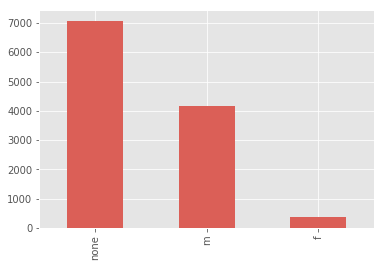

In [65]:
digits.gender.value_counts().plot(kind='bar')

In [66]:
authors_digits = credible_authors.reset_index().merge(digits, left_on='author', right_on='name')

In [67]:
digiAuthorPublicationData = authorPublicationData.merge(authors_digits, how="inner", on=["author"])

In [68]:
authors_digits.shape

(5880, 12)

In [69]:
print("Percentage of authors with numbers in names: ", authors_digits.shape[0]*100/credible_authors.shape[0])
print("Percentage of publications: ", authors_digits.num_pub.sum()*100/credible_authors.num_pub.sum())
print("Percentage of citations: ", authors_digits.final_citation_count.sum()*100/credible_authors.final_citation_count.sum())

Percentage of authors with numbers in names:  1.1669931468922854
Percentage of publications:  2.0680998909247443
Percentage of citations:  2.5078878280468806


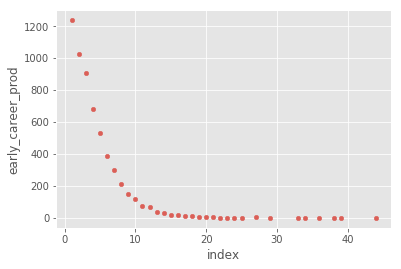

In [72]:
authors_digits.early_career_prod.value_counts().reset_index().plot(kind='scatter', x='index', y='early_career_prod')

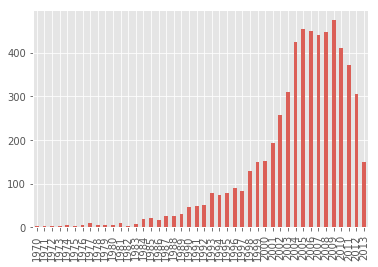

In [73]:
authors_digits.start_year.value_counts().sort_index().plot(kind='bar')

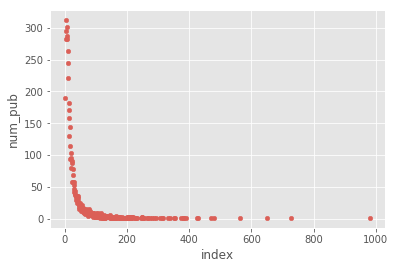

In [74]:
authors_digits.num_pub.value_counts().reset_index().plot(kind='scatter', x='index', y='num_pub')

In [75]:
authors_digits['pub_per_year'] = authors_digits.num_pub / authors_digits.career_length

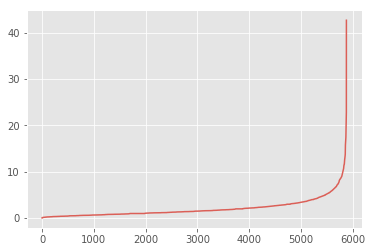

In [76]:
plt.plot(sorted(authors_digits['pub_per_year']))
plt.show()

In [77]:
authors_digits[authors_digits['pub_per_year'] > 10]

,author,start_year,end_year,num_pub,career_length,early_career_prod,early_career_qual,early_career_rec,final_citation_count,gender_x,name,gender_y,pub_per_year
58,albrecht schmidt 1,1998,2017,339,20,16,127.0,35,5287.0,m,albrecht schmidt 1,m,16.950000
225,anil k. jain 1,1976,2017,425,42,3,13.0,1,26756.0,m,anil k. jain 1,m,10.119048
335,bernd becker 1,1983,2017,352,35,2,0.0,0,2602.0,m,bernd becker 1,m,10.057143
361,bin liu 1,2003,2017,155,15,23,44.0,9,1240.0,none,bin liu 1,none,10.333333
572,chao wang 3,2011,2017,76,7,38,101.0,57,179.0,none,chao wang 3,none,10.857143
623,cheng wang 3,2013,2017,58,5,34,105.0,35,123.0,none,cheng wang 3,none,11.600000
946,david zhang 1,1994,2017,481,24,6,0.0,0,11643.0,none,david zhang 1,none,20.041667
1115,fei wang 1,2004,2017,159,14,11,55.0,14,2508.0,none,fei wang 1,none,11.357143
1479,haris aziz 1,2008,2017,104,10,11,206.0,75,963.0,m,haris aziz 1,m,10.400000
1593,hui li 6,2007,2017,179,11,9,4.0,0,1038.0,none,hui li 6,none,16.272727


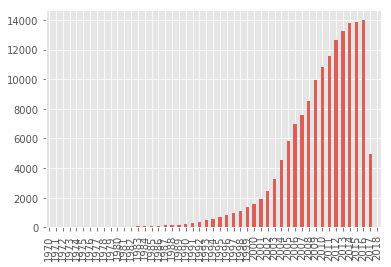

In [78]:
digiAuthorPublicationData.year.value_counts().sort_index().plot(kind='bar')

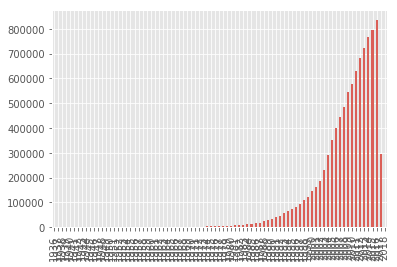

In [79]:
authorPublicationData.year.value_counts().sort_index().plot(kind='bar')

## Citations distribution (based on IDs file)

In [80]:
citation_distribution = credible_authors['final_citation_count'].value_counts().sort_index()

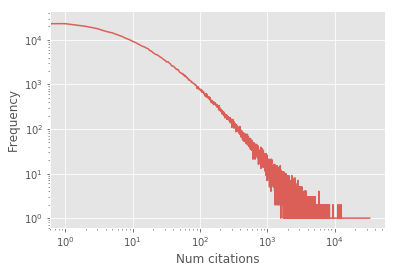

In [81]:
plt.loglog(citation_distribution.index, citation_distribution.values)
plt.xlabel('Num citations')
plt.ylabel('Frequency')
plt.show()

## Early Career Prod. vs Final Success (ID file)

In [82]:
credible_authors.sort_values(by='early_career_prod', inplace=True)

In [83]:
x = credible_authors['early_career_prod']
y = credible_authors['final_citation_count']

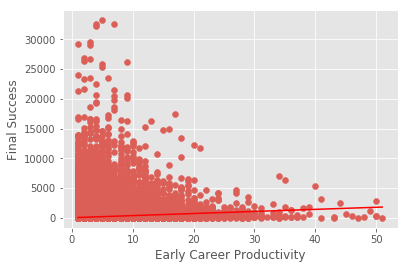

In [84]:
fig, ax = plt.subplots()
plt.scatter(x, y)
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Early Career Productivity')
plt.ylabel('Final Success')
# plt.xlim(0, 50)
# plt.ylim(0,200)
plt.show()

In [85]:
credible_authors_no_uncited = credible_authors.dropna()

In [86]:
x = credible_authors_no_uncited['early_career_prod']
y = credible_authors_no_uncited['final_citation_count']

In [87]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value)
print(slope, intercept)

0.1599975788916418
34.960743634955534 38.4926283228165


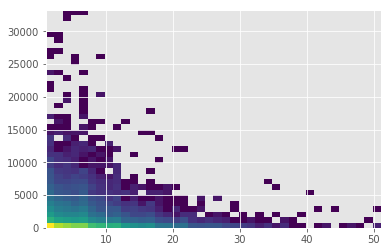

In [88]:
fig, axs = plt.subplots()
axs.hist2d(x, y, bins=40, norm=colors.LogNorm())
plt.show()

## Early Career Prod. vs Early Career Qual. (IDs file)

In [89]:
credible_authors.sort_values(by='early_career_prod', inplace=True)

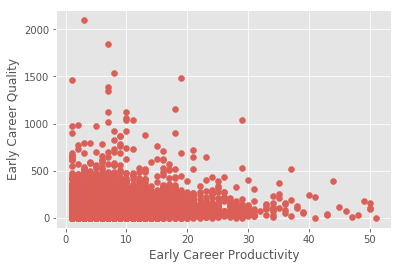

In [90]:
plt.scatter(credible_authors['early_career_prod'], credible_authors['early_career_qual'])
plt.xlabel('Early Career Productivity')
plt.ylabel('Early Career Quality')
plt.show()